In [2]:
import cv2
import cv2 as cv
import numpy as np
import matplotlib.pyplot as plt

RECT_PATH = "rect.jpeg"
img = cv2.imread(RECT_PATH)

In [3]:
grey = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
blurred = cv2.GaussianBlur(grey, (5, 5), 2, 2)

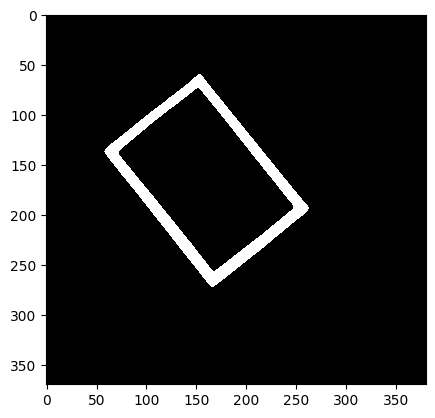

In [4]:
ok, binary = cv2.threshold(blurred, 0, 255, cv2.THRESH_BINARY | cv2.THRESH_OTSU)
inv_binary = cv2.bitwise_not(binary)
plt.imshow(inv_binary, cmap='gray')

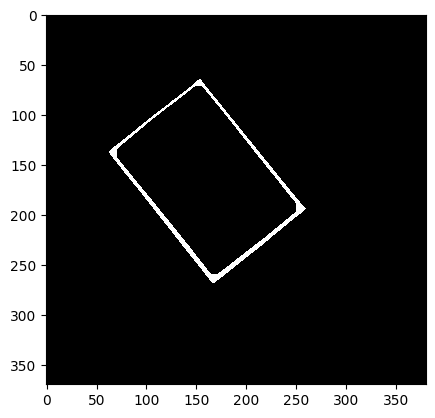

In [5]:
kernel = np.ones((5,5),np.uint8)
opened = cv2.morphologyEx(inv_binary, cv2.MORPH_OPEN, kernel)
kernel = np.ones((6,6),np.uint8)
eroded = cv2.erode(opened, kernel, iterations=1)
plt.imshow(eroded, cmap='gray')

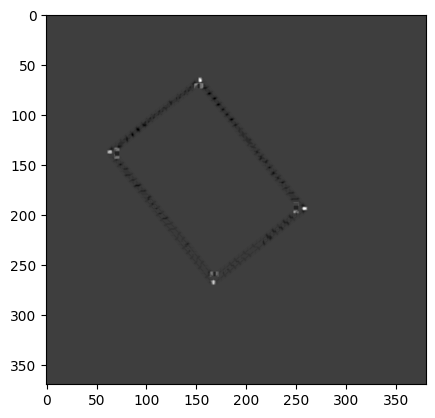

In [112]:
# try these?
# https://docs.opencv.org/4.8.0/df/d0c/tutorial_py_fast.html
# https://docs.opencv.org/4.8.0/dc/d0d/tutorial_py_features_harris.html
# https://docs.opencv.org/4.8.0/db/d27/tutorial_py_table_of_contents_feature2d.html
dst = cv2.cornerHarris(eroded, 5, 3, 0.04)
plt.imshow(dst, cmap='gray')

In [185]:
Point = tuple[float, float]
from typing import Iterator, List
def merge_points(points: Iterator[Point], r: float = 10) -> List[Point]:
    def is_in_circle(center: Point, point: Point, radius: float) -> bool:
        x1, y1 = center
        x2, y2 = point
        return np.linalg.norm(np.array([x1, y1]) - np.array([x2, y2])) < radius

    pts = list(points)
    ret = []
    while len(pts) > 0:
        center = pts.pop()
        suppressed = [point for point in pts if is_in_circle(center, point, r)]
        for point in suppressed:
            pts.remove(point)
        ret.append(center)
    return ret


threshold: 0.0033618003129959107
x: 168, y: 270
x: 248, y: 199
x: 72, y: 144
x: 155, y: 74


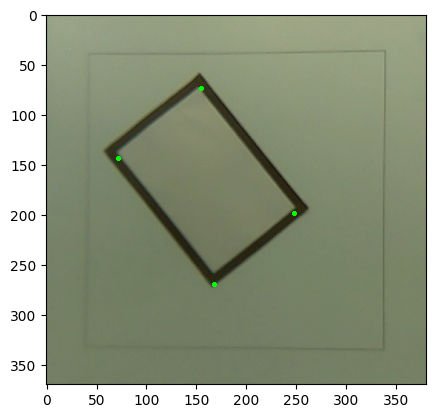

In [186]:
res = img.copy()
mask = dst.copy()
THRESHOLD = 0.075
threshold = THRESHOLD * mask.max()
assert(0 <= THRESHOLD and THRESHOLD <= 1)
print("threshold: {}".format(threshold))
mask[mask > threshold] = 255
mask[mask <= threshold] = 0

many_pts = list(map(lambda x: (x[0][0], x[0][1]), cv2.findNonZero(mask)))
merged = merge_points(many_pts, 100)
for p in merged:
    print("x: {}, y: {}".format(p[0], p[1]))
    cv2.circle(res, p, 1, (0, 255, 0), 2)


plt.imshow(res, cmap='gray')


x: 165.0, y: 57.0, r: 7.599999904632568
x: 83.0, y: 127.0, r: 7.599999904632568
x: 183.0, y: 249.0, r: 5.400000095367432
x: 271.0, y: 187.0, r: 7.599999904632568


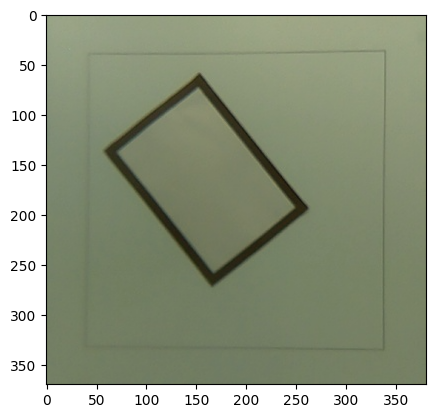

In [190]:
res_hough = img.copy()
# will the HoughCircles too expensive? We have get a clear boundary
# so simple algorithm is more suitable I think

# merge similar regions
kernel = np.ones((8, 8), np.uint8)
mask_dilated = cv2.dilate(mask, kernel, iterations=1).astype(np.uint8)
# similar points to one
h, w = mask_dilated.shape
circles = cv2.HoughCircles(
    mask_dilated,
    method=cv2.HOUGH_GRADIENT,
    dp=2,
    minDist= w / 5,
    param1=3,
    param2=3,
    minRadius=3,
    maxRadius=9)
for c in circles[0,:]:
    if c is not None:
        x, y, r = c
        print("x: {}, y: {}, r: {}".format(x, y, r))
        x = int(x)
        y = int(y)
        r = int(r)
        cv2.circle(res_hough, (x, y), r, (0, 255, 0), 2)

plt.imshow(res_hough)

x: 165.0, y: 270.0
x: 261.0, y: 195.0
x: 72.0, y: 138.0
x: 152.0, y: 75.0
Threshold: 10
nonmaxSuppression:False
neighborhood: 0
Total Keypoints with nonmaxSuppression: 4


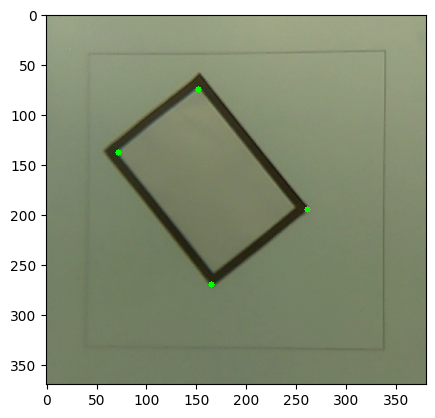

In [187]:
# play with FAST
res = img.copy()

# https://docs.opencv.org/4.8.0/df/d74/classcv_1_1FastFeatureDetector.html
fast = cv2.FastFeatureDetector_create()
# https://docs.opencv.org/4.x/de/db2/classcv_1_1KeyPointsFilter.html
kps = fast.detect(blurred, None)
fast.setThreshold(10)
fast.setNonmaxSuppression(False)
fast.setType(cv2.FAST_FEATURE_DETECTOR_TYPE_5_8)
# cv2.drawKeypoints(None, kp, res, color=(0, 255, 0), flags=cv2.DRAW_MATCHES_FLAGS_DRAW_OVER_OUTIMG)
def kp_to_tuple(keypoint):
    return keypoint.pt

kps = list(merge_points(map(kp_to_tuple, kps), 50))

for point in kps:
    x, y = point
    print("x: {}, y: {}".format(x, y))
    cv2.circle(res, (int(x), int(y)), 3, (0, 255, 0), -1)
# Print all default params
print( "Threshold: {}".format(fast.getThreshold()) )
print( "nonmaxSuppression:{}".format(fast.getNonmaxSuppression()) )
print( "neighborhood: {}".format(fast.getType()) )
print( "Total Keypoints with nonmaxSuppression: {}".format(len(kps)) )

plt.imshow(res)